In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/My\ Drive/Pathology/histopathologic-cancer-detection/test | wc -l

14743


In [ ]:
!ls drive/My\ Drive/Pathology/histopathologic-cancer-detection/train | wc -l

23837


In [ ]:
working_dir = "drive/My Drive/Pathology/histopathologic-cancer-detection/"

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
import os
print(os.listdir(working_dir))
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.__version__

['test', 'train', 'train_labels.csv', 'sample_submission.csv']


'2.2.0-rc4'

In [ ]:
df = pd.read_csv( working_dir + 'train_labels.csv')

In [ ]:
df.head

<bound method NDFrame.head of                                               id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]>

In [ ]:
df_train_paths = glob.glob(working_dir + 'train/*.tif')
df_test_paths = glob.glob(working_dir + 'test/*.tif')

In [ ]:
len(df_train_paths)

23837

In [ ]:
df_train_paths[:5]

['drive/My Drive/Pathology/histopathologic-cancer-detection/train/7817d5c8c1d05afc5a8809f69677666ddc92931d.tif',
 'drive/My Drive/Pathology/histopathologic-cancer-detection/train/80a096b61f7f51d1b168645c56fae2b0d05884dc.tif',
 'drive/My Drive/Pathology/histopathologic-cancer-detection/train/baa0ff233737846b1c41957a81d7d274d8344bd1.tif',
 'drive/My Drive/Pathology/histopathologic-cancer-detection/train/b60fd9f1191a6473386254d4282216074a30e16d.tif',
 'drive/My Drive/Pathology/histopathologic-cancer-detection/train/c82504849073f22d299d2dae0493b2c45e0cfc9a.tif']

In [ ]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [ ]:
def label_mapping(data):
    return data.split('/')[-1].replace('.tif','')

In [ ]:
label_mapping('drive/My Drive/Pathology/histopathologic-cancer-detection/train/7817d5c8c1d05afc5a8809f69677666ddc92931d.tif')

'7817d5c8c1d05afc5a8809f69677666ddc92931d'

In [ ]:
id_label = {k:v for k,v in zip(df.id.values,df.label.values)}

In [ ]:
def give_label(img_path):
    return id_label[img_path]

def get_batch(data, batch_size):
    return (data[i:i+batch_size] for i in range(0, len(data), batch_size))   

def data_aug(img_data,train_label_mapping,batch_size,augment = False):
    seq = get_seq()
    while True:
        random.shuffle(img_data)
        for batch in get_batch(img_data,batch_size):
            X = [cv2.imread(img_path) for img_path in batch]
            y = [train_label_mapping[get_id_from_img_path(img_path)] for img_path in batch]
            
            if augment:
                X = seq.augment_images(X)
    
            yield np.array(X), np.array(y)

In [ ]:
df_main = pd.DataFrame({'img_path':df_train_paths})

In [ ]:
df_main.head()

,img_path
0,drive/My Drive/Pathology/histopathologic-cance...
1,drive/My Drive/Pathology/histopathologic-cance...
2,drive/My Drive/Pathology/histopathologic-cance...
3,drive/My Drive/Pathology/histopathologic-cance...
4,drive/My Drive/Pathology/histopathologic-cance...


In [ ]:
df_main['id'] = df_main['img_path'].apply(label_mapping)

In [ ]:
df_main.tail()

,img_path,id
23832,drive/My Drive/Pathology/histopathologic-cance...,39a92a087b89ab26ccc43f1b31a219b4fce809d7
23833,drive/My Drive/Pathology/histopathologic-cance...,1ea908dfe7ec04c063dfa2fded02180760dbfa53
23834,drive/My Drive/Pathology/histopathologic-cance...,273ecf4b720df85e42e6cd941c7c799772b6bd04
23835,drive/My Drive/Pathology/histopathologic-cance...,67d8d8312b1a8179cfd80bcdb67c37d84977a06c
23836,drive/My Drive/Pathology/histopathologic-cance...,9337e9a0c398985ee1ee12f0b6d23cd65a7a125e


In [ ]:
df = df.merge(df_main,on='id')

In [ ]:
df.describe()

,label
count,23837.000000
mean,0.406553
std,0.491200
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df0 = df[df['label'] == 0].sample(5000,random_state=42)
df1 = df[df['label'] == 1].sample(5000,random_state=42)

In [ ]:
df = pd.concat([df0,df1], ignore_index=True)

In [ ]:
df.describe()

,label
count,10000.000000
mean,0.500000
std,0.500025
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
df_train, df_val = train_test_split(df, random_state=42,test_size=0.2)

In [ ]:
df_train.head()

,id,label,img_path
9254,41f84df42dccdbf0b650795333e400c8144b250c,1,drive/My Drive/Pathology/histopathologic-cance...
1561,7597323fff3d0847439a359fb4746338b3bf77f2,0,drive/My Drive/Pathology/histopathologic-cance...
1670,57360b064d0a25d8f78f17f620c2e95cb4f62a36,0,drive/My Drive/Pathology/histopathologic-cance...
6087,c27eae71ce9c806318acdb553112ebea360f5f50,1,drive/My Drive/Pathology/histopathologic-cance...
6669,66a5594bef08f73cff1b8e173cf9f2389bbb19a6,1,drive/My Drive/Pathology/histopathologic-cance...


In [ ]:
df_val.shape

(2000, 3)

In [ ]:
train_imgs = [cv2.imread(img_path) for img_path in list(df_train['img_path'])]
val_imgs = [cv2.imread(img_path) for img_path in list(df_val['img_path'])]

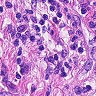

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(train_imgs[100])


In [ ]:
train_imgs[3].shape

(96, 96, 3)

In [ ]:
train_imgs = np.array(train_imgs)
val_imgs = np.array(val_imgs)

In [ ]:
train_imgs.shape

(8000, 96, 96, 3)

In [ ]:
val_imgs.shape

(2000, 96, 96, 3)

In [ ]:
#train_images = train_images.reshape((500, 96, 96, 3))
#train_images = train_images.astype('float32') / 255

#test_images = test_images.reshape((500, 28, 28, 1))
#test_images = test_images.astype('float32') / 255


train_imgs = train_imgs.astype('float32') / 255
val_imgs = val_imgs.astype('float32') / 255

In [ ]:
train_imgs[1]

array([[[0.6431373 , 0.5294118 , 0.72156864],
        [0.21176471, 0.08627451, 0.2784314 ],
        [0.36078432, 0.20784314, 0.4117647 ],
        ...,
        [0.13333334, 0.        , 0.07058824],
        [0.2901961 , 0.15686275, 0.2509804 ],
        [1.        , 0.9607843 , 1.        ]],

       [[0.7647059 , 0.6156863 , 0.8039216 ],
        [0.4       , 0.2509804 , 0.4392157 ],
        [0.25490198, 0.10588235, 0.3019608 ],
        ...,
        [0.31764707, 0.1254902 , 0.2509804 ],
        [0.2784314 , 0.14509805, 0.23921569],
        [0.69411767, 0.61960787, 0.6862745 ]],

       [[0.5647059 , 0.36078432, 0.54509807],
        [0.37254903, 0.18431373, 0.37254903],
        [0.35686275, 0.20392157, 0.38431373],
        ...,
        [0.32941177, 0.14509805, 0.27058825],
        [0.3019608 , 0.1764706 , 0.27450982],
        [0.44313726, 0.3529412 , 0.4392157 ]],

       ...,

       [[0.7921569 , 0.6862745 , 0.8392157 ],
        [0.60784316, 0.5137255 , 0.64705884],
        [0.89411765, 0

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [EarlyStopping(monitor='auc_roc', patience=300, verbose=1, mode='max')]

In [ ]:
batch_size = 32
model.fit(train_imgs,df_train['label'], batch_size = batch_size,epochs=28,validation_data=(val_imgs,df_val['label']), callbacks=my_callbacks)




Train on 8000 samples, validate on 2000 samples
Epoch 1/28





8000/8000 [==============================] - 159s 20ms/step - loss: 0.5897 - acc: 0.6896 - val_loss: 0.5476 - val_acc: 0.7245
Epoch 2/28


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `auc_roc` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


8000/8000 [==============================] - 156s 19ms/step - loss: 0.5064 - acc: 0.7610 - val_loss: 0.5529 - val_acc: 0.7330
Epoch 3/28
8000/8000 [==============================] - 159s 20ms/step - loss: 0.4934 - acc: 0.7692 - val_loss: 0.4829 - val_acc: 0.7695
Epoch 4/28
8000/8000 [==============================] - 163s 20ms/step - loss: 0.4870 - acc: 0.7746 - val_loss: 0.5152 - val_acc: 0.7605
Epoch 5/28
8000/8000 [==============================] - 157s 20ms/step - loss: 0.4765 - acc: 0.7829 - val_loss: 0.4621 - val_acc: 0.7910
Epoch 6/28
8000/8000 [==============================] - 156s 20ms/step - loss: 0.4728 - acc: 0.7837 - val_loss: 0.4587 - val_acc: 0.7980
Epoch 7/28
8000/8000 [==============================] - 151s 19ms/step - loss: 0.4685 - acc: 0.7895 - val_loss: 0.4618 - val_acc: 0.7910
Epoch 8/28
8000/8000 [==============================] - 146s 18ms/step - loss: 0.4595 - acc: 0.7943 - val_loss: 0.4852 - val_acc: 0.7765
Epoch 9/28
8000/8000 [==============================

In [ ]:
pred = (model.predict(val_imgs).ravel()*model.predict(val_imgs[:,::-1,:,:]).ravel()*model.predict(val_imgs[:,:,::-1,:]).ravel()*model.predict(val_imgs[:,::-1,::-1,:]).ravel())**0.25
roc_auc_score(df_val['label'],pred)

0.8970531756572947

In [ ]:
model.save('pathology1_8k_2k.h5')

In [ ]:
test_imgs = [cv2.imread(img_path) for img_path in df_test_paths]
test_imgs = np.array(test_imgs)
test_imgs.shape
predtest = (model.predict(test_imgs).ravel()*model.predict(test_imgs[:,::-1,:,:]).ravel()*model.predict(test_imgs[:,:,::-1,:]).ravel()*model.predict(test_imgs[:,::-1,::-1,:]).ravel())**0.25
id = []
for path in df_test_paths:
    id.append(label_mapping(path))
submit = pd.DataFrame({'id':id,'label':predtest})
submit.to_csv("sub_new.csv",index=False)

Improvement thoughts:

1. organize data directory as below. Then use ImageDataGenerator flow_from_directory to save time 
  Train
    Positive
    Negative
  Test
    Positive
    Negative
2. Load full data set
3. Preprosessing
4. finetune some CNN parameters

In [ ]:
'''
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        # This is the target directory
        dataframe = ,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=df, directory=".\train_imgs", x_col="id", y_col="label", class_mode="categorical", target_size=(32,32), batch_size=32)

'''